This code is to optimize TDA.ipynb file, the main change is using three main function as the filter function:
1. Eccentricity
2. PCA
3. KDE

In [ ]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

import ast
import pandas as pd
import numpy as np

import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tdam.cover import CubicalCover
from tdam.clustering import FailSafeClustering
from tdam.core_old import MapperAlgorithm
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, normalize

In [ ]:
import geopandas as gpd
from shapely import wkt

TM2 = 3826

# 原始以 0.001 grid 計算出的區域事故及對應索引, 依照 hex_grid 計算出來的GI
grid_gi_df = pd.read_csv('../ComputedData/Grid/grid_gi.csv')
grid_gi_df['accident_indices'] = grid_gi_df['accident_indices'].apply(ast.literal_eval)
grid_gi_df['geometry'] = grid_gi_df['geometry'].apply(wkt.loads)
grid_gi  = gpd.GeoDataFrame(grid_gi_df, geometry='geometry').set_crs(TM2, allow_override=True)
grid_gi['geometry'] = grid_gi.geometry.centroid

# 熱點屬於哪一個城市
taiwan = gpd.read_file('../Data/OFiles_9e222fea-bafb-4436-9b17-10921abc6ef2/TOWN_MOI_1140318.shp')
taiwan = taiwan[(~taiwan['TOWNNAME'].isin(['旗津區', '頭城鎮', '蘭嶼鄉', '綠島鄉', '琉球鄉'])) & 
                (~taiwan['COUNTYNAME'].isin(['金門縣', '連江縣', '澎湖縣']))].to_crs(TM2)
taiwan_cnty = taiwan[['COUNTYNAME','geometry']].dissolve(by='COUNTYNAME')
taiwan_cnty['geometry'] = taiwan_cnty.buffer(0)

county_join = gpd.sjoin(grid_gi[['geometry']], taiwan_cnty, how='left', predicate='within')
grid_gi['COUNTYNAME'] = county_join['COUNTYNAME']

grid_filter = grid_gi[grid_gi['accident_indices'].str.len() > 0]
grid_filter.reset_index(inplace=True)

In [ ]:
# This is same as all_features but adding hotspot only
all_features_df = pd.read_csv("../ComputedData/ForModel/all_featuresV2.csv")

cols1 = all_features_df.columns[all_features_df.columns.str.contains('事故位置大類別名稱')]
cols2 = all_features_df.columns[all_features_df.columns.str.contains('號誌動作')]
cols3 = all_features_df.columns[all_features_df.columns.str.contains('hotspot')]

all_features_df.drop(columns=cols1, inplace=True)
all_features_df.drop(columns=cols2, inplace=True)
all_features_df.drop(columns=cols3, inplace=True)

# Mapper
Get filtered_data by running FilterforMapper.py

In [ ]:
filter_full = pd.read_csv("../ComputedData/ForModel/filtered_data_test.csv")
filter_full.drop(columns=['pc4', 'pc5'], inplace=True)

overlaps = [3]
intervals = [10]
detailed_results = []
silhouette_for_intervals = []

for overlap in overlaps:
    for interval in intervals:
        print(f"Processing overlap {overlap}, interval {interval}")
        mapper_algo = MapperAlgorithm(
            cover=CubicalCover(
                n_intervals=interval,
                overlap_frac=overlap / 10
            ),
            clustering=FailSafeClustering(
                KMeans(
                    n_clusters=2,
                    random_state=42
                )
            ),
            n_jobs=-1
        )

        mapper_info = mapper_algo.fit_transform(all_features_df.to_numpy(), filter_full)

        silhouette_for_intervals.append(mapper_info[1])
        result = {
            "overlap": overlap,
            "interval": interval,
            "silhouette": mapper_info[1],
            "mapper_info": mapper_info
        }
        detailed_results.append(result)

        with open(f"../ComputedData/ForMatrixV2/o{overlap}i{interval}_test.pkl", 'wb') as file:
            pickle.dump(result, file)

detailed_results_df = pd.DataFrame(detailed_results)

In [ ]:
# from utils_tda import get_max_categories
def get_max_categories(row):

    cols = all_features_df.columns[all_features_df.columns.str.contains(col)]

    max_val = row[cols].max()
    max_cols = row[cols][row[cols] == max_val].index
    # 取底線後面的類別名稱，用逗號串起來
    return ','.join(col.split('_')[-1] for col in max_cols)

col = '道路類別-第1當事者-名稱'
all_features_df['最高類別'] = all_features_df.apply(get_max_categories, axis=1)
all_features_df['最高類別'].value_counts()

all_features_df['county'] = grid_filter['COUNTYNAME']
all_features_df['hotspot'] = grid_filter['hotspot']
all_features_df['county_city'] = all_features_df['county'].apply(lambda x: 'City' if '市' in str(x) else 'County')
all_features_df['hotspot'] = all_features_df['hotspot'].apply(lambda x: 'Hotspot' if 'Hotspot' in str(x) else 'Not Hotspot')

all_features_df['facility'] = all_features_df[['youbike_100m_count_mean', 'mrt_100m_count_mean', 'parkinglot_100m_count_mean']].apply(
    lambda row: '1' if (row > 0).any() else '0', axis=1
)
all_features_df['hotspot_facility'] = all_features_df['hotspot'] + '_' + all_features_df['facility']
all_features_df['facility'] = all_features_df['facility'].astype(int) 

all_features_df_speed = pd.read_csv('../ComputedData/ForModel/all_features_df-速限.csv')
all_features_df['original_speed'] = all_features_df_speed['速限-第1當事者_mean']

all_features_df['最高類別2'] = all_features_df.apply(
    lambda row: '市區道路' if (row['最高類別'] == '市區道路') else '非市區道路',
    axis=1
)
all_features_df['bn_feature'] = all_features_df.apply(
    lambda row: 1 if (
        (
        (
            (row['道路型態大類別名稱_單路部分'] > 0) or
            (row['道路型態大類別名稱_其他'] > 0) or
            (row['道路型態大類別名稱_圓環廣場'] > 0) or
            (row['道路型態大類別名稱_平交道'] > 0) or
            (row['道路型態大類別名稱_交岔路'] > 0)
            ) and
        (
            (row['號誌-號誌種類名稱_行車管制號誌(附設行人專用號誌)'] > 0) or
            (row['號誌-號誌種類名稱_行車管制號誌'] > 0) or
            (row['號誌-號誌種類名稱_閃光號誌'] > 0) or
            (row['號誌-號誌種類名稱_無號誌'] > 0)
            ) and
        (
            (row['道路類別-第1當事者-名稱_市區道路'] > 0)
            ) and
        (
            (row['original_speed'] < 50)
            ) and
        (
            (row['facility'] > 0)
            )
        )
    ) else 0,
    axis=1
)

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
# from utils_tda import avg_label, most_common_encoded_label, cond_prob_mixed

# use this for finding specific value ratios in a column
def ratio_in_data(data, col='hotspot', values='Hotspot'):
    """
    choose = 'county_city'
    """
    # 取出要判斷的 Series
    if isinstance(data, pd.DataFrame):
        s = data[col].astype(str)
    else:
        s = pd.Series(data).astype(str)

    # 正規化欲比對的值集合
    if isinstance(values, (list, tuple, set)):
        target = set(map(str, values))
        mask = s.isin(target)
    else:
        mask = (s == str(values))

    return float(mask.mean())

def linf_centrality_exact(df, block_size = 2000):
    """
    回傳 shape=(n,1) 的 L∞ centrality（每點到最遠點的距離）。
    - metric: "cosine" 或 "euclidean"
    - block_size: 控制記憶體 (block_size * n distances)
    """
    X = df.to_numpy(dtype=float)
    n = X.shape[0]
    # 對每一列作 L2 正規化才能用 cosine 距離
    X = normalize(X, norm="l2", axis=1)

    # 準備結果陣列，初始為無窮小
    max_d = np.full(n, -np.inf, dtype=float)
    order = np.arange(n) # 保留原順序
    
    # 分塊計算 pairwise 距離以控制記憶體
    for start in range(0, n, block_size):
        idx = order[start:start+block_size]
        D_blk = pairwise_distances(X[idx], X, metric='cosine')  # (b, n)
        # 自身距離設為 -inf，避免影響 max
        D_blk[np.arange(D_blk.shape[0]), idx] = -np.inf
        # 針對每個 i（在 idx 中），更新它的全域最遠距離
        max_d[idx] = np.maximum(max_d[idx], D_blk.max(axis=1))

    return max_d.reshape(-1, 1)

def get_max_categories(row):

    cols = all_features_df.columns[all_features_df.columns.str.contains(col)]

    max_val = row[cols].max()
    max_cols = row[cols][row[cols] == max_val].index
    # 取底線後面的類別名稱，用逗號串起來
    return ','.join(col.split('_')[-1] for col in max_cols)

def avg_label(data):
    """
    choose = 'original_speed'
    """
    return sum(data) / len(data) if len(data) > 0 else 0

def most_common_encoded_label(data):
    """
    choose = 'hotspot_facility'
    """
    return Counter(data).most_common(1)[0][0]

# conditional probability
def cond_prob_mixed(
        subdf, 
        a_col='hotspot', 
        a_is='Hotspot', 
        b_col='bn_feature', 
        b_rule=">0",
        alpha=0.5, min_den=0, condition="B|A"
    ):
    """
    回傳條件機率：
        - A : 類別欄位, a_is 可為 str 或 可迭代(多類別集合)
        - B : 可為數值/比例欄位，用 b_rule 指定成立條件(或傳入 callable)
        - alpha : Laplace smoothing
        - min_den : A 成立的樣本至少要有幾個，否則回 NaN
        - condition="B|A": P(B | A)(預設；與你原本一致，分母=|A|)
        - condition="A|B": P(A | B)(反過來，分母=|B|)

    其他參數說明同前。
    """

    # A: 類別欄位是否落在 a_is 這個集合
    Aset = {a_is} if isinstance(a_is, str) else set(a_is)
    A = subdf[a_col].astype(str)
    mask_A = A.isin(Aset)

    # B: 數值/比例欄位是否滿足 b_rule
    s = pd.to_numeric(subdf[b_col], errors='coerce')
    if callable(b_rule):
        mask_B = b_rule(s)
    else:
        rule = str(b_rule).strip()
        if rule == ">0":
            mask_B = (s > 0)
        elif rule == ">=0":
            mask_B = (s >= 0)
        elif rule.startswith(">="):
            thr = float(rule[2:]); mask_B = (s >= thr)
        elif rule.startswith(">"):
            thr = float(rule[1:]); mask_B = (s > thr)
        elif rule.startswith("<="):
            thr = float(rule[2:]); mask_B = (s <= thr)
        elif rule.startswith("<"):
            thr = float(rule[1:]); mask_B = (s < thr)
        elif rule.startswith("=="):
            thr = float(rule[2:]); mask_B = (s == thr)
        else:
            raise ValueError("Unknown b_rule")

    # 共同分子
    num = (mask_A & mask_B).sum()

    # 選擇分母（誰是條件）
    if condition.upper() == "B|A":
        den = mask_A.sum()    # P(B|A)
    elif condition.upper() == "A|B":
        den = mask_B.sum()    # P(A|B)
    else:
        raise ValueError("condition must be 'B|A' or 'A|B'")

    if den < min_den:
        return float('nan')

    # 對稱的拉普拉斯平滑
    return float((num + alpha) / (den + 2 * alpha))

# # 用來檢查條件機率效果
# test = all_features_df[['hotspot', '號誌-號誌種類名稱_行車管制號誌']].copy()
# test['號誌-號誌種類名稱_行車管制號誌'] = test['號誌-號誌種類名稱_行車管制號誌'].apply(lambda x: 1 if x > 0.5 else 0)
# test[['hotspot', '號誌-號誌種類名稱_行車管制號誌']].value_counts()

In [ ]:
from TrafficTDApythonUtils.plotsv2 import MapperPlotterSpring

oi = 'o3i10'
choose = '最高類別'

detailed_results_df = pickle.load(open(f"../ComputedData/ForMatrixV2/{oi}.pkl", "rb"))
mapper_plotter = MapperPlotterSpring(
    detailed_results_df['mapper_info'],
    all_features_df,
    seed=47, iterations=100, dim=2,
    range_lst=[-0.5, 0.5, 0.5, -0.5],
    cmap="Reds",
    encoded_label=most_common_encoded_label
)
mapper_plotter.create_mapper_plot(choose, avg=False, size_threshold=50, plot_type='spring')
full_info, outliers = mapper_plotter.extract_data()
mapper_plotter.map_colors(threshold=0)
mapper_plotter.plot(set_label=True, size=500, anchor=(0,0),
                    # save_path=f"../ComputedData/ForMatrixV2/Plots/{oi}.png"
                    )

In [ ]:
from TrafficTDApythonUtils.plotsv2 import MapperPlotterSpring

choose = '最高類別'

detailed_results_df = pickle.load(open(f"../ComputedData/ForMatrixV2/o3i10_test.pkl", "rb"))

for i in range(105, 130):
    mapper_plotter = MapperPlotterSpring(
        detailed_results_df['mapper_info'],
        all_features_df,
        seed=i, iterations=100, dim=2,
        range_lst=[-0.5, 0.5, 0.5, -0.5],
        cmap="Reds",
        encoded_label=most_common_encoded_label
    )
    mapper_plotter.create_mapper_plot(choose, avg=False, size_threshold=50, plot_type='spring')
    full_info, outliers = mapper_plotter.extract_data()
    mapper_plotter.map_colors(threshold=0)
    mapper_plotter.plot(set_label=True, size=500, anchor=(0,0),
                        save_path=f"../ComputedData/ForMatrixTest/{i}_{choose}.png"
                        )

Creating spring layout...
Mapper layout computed. nodes=1448
Data extracted.
Mapping colors...
Colors mapped.
Plotting...
Plot saved to ../ComputedData/ForMatrixTest/14_最高類別2.png


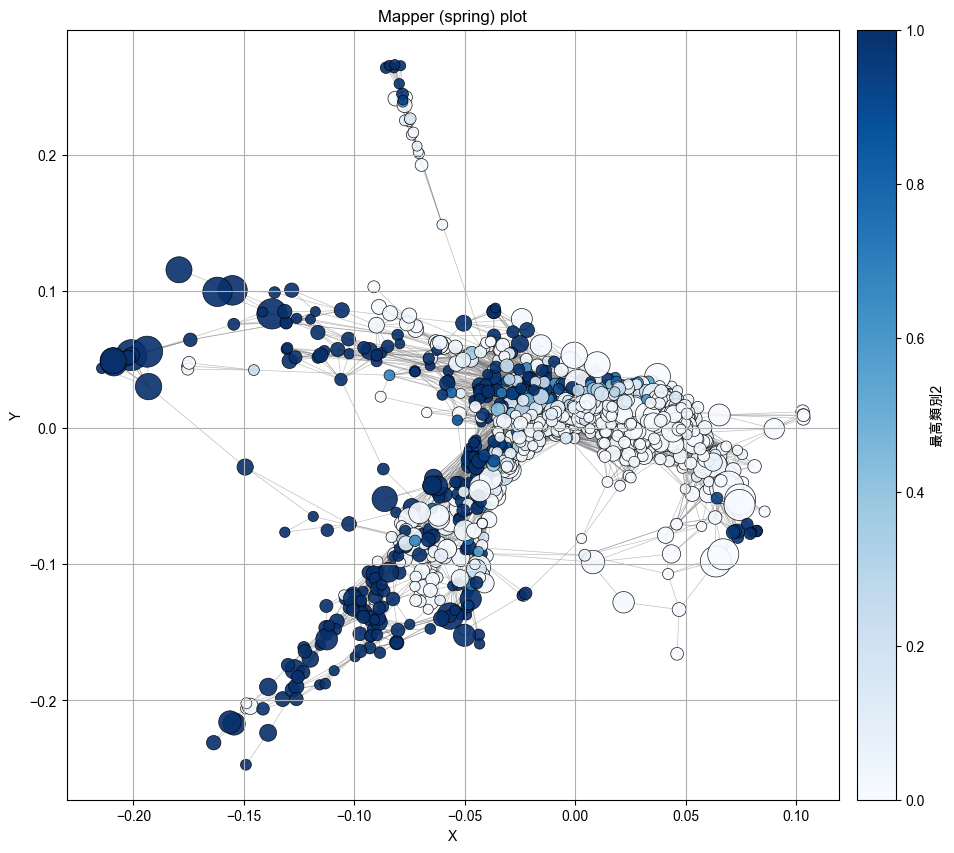

In [ ]:
books = { 
    '最高類別2': {
        'label': ratio_in_data,
        'avg': True,
        'params': {'col': '最高類別2', 'values': '非市區道路'},
        'color': 'Blues',
    },
    # ('hotspot', '車道劃分設施-分道設施-路面邊線名稱_無'): {
    #     'label': cond_prob_mixed,
    #     'avg': True,
    #     'params': {'a_col': 'hotspot', 'a_is': 'Hotspot',
    #                'b_col': '車道劃分設施-分道設施-路面邊線名稱_無', 'b_rule': '>0'},
    #     'color': 'Blues'
    # },
    # ('hotspot', '號誌-號誌種類名稱_行車管制號誌'): {
    #     'label': cond_prob_mixed,
    #     'avg': True,
    #     'params': {'a_col': 'hotspot', 'a_is': 'Hotspot',
    #                'b_col': '號誌-號誌種類名稱_行車管制號誌', 'b_rule': '>0'},
    #     'color': 'Blues'
    # },
    # ('hotspot', 'facility'): {
    #     'label': cond_prob_mixed,
    #     'avg': True,
    #     'params': {'a_col': 'hotspot', 'a_is': 'Hotspot',
    #                'b_col': 'facility', 'b_rule': '>0'},
    #     'color': 'Blues'
    # },
    # 'hotspot': {
    #     'label': ratio_in_data,
    #     'avg': True,
    #     'params': {'col': 'hotspot', 'values': 'Hotspot'},
    #     'color': 'Greens'
    #     },
    # 'bn_feature': {
    #     'label': ratio_in_data,
    #     'avg': True,
    #     'params': {'col': 'bn_feature', 'values': 1},
    #     'color': 'Reds'
    # },
    # 'county_city': {
    #     'label': ratio_in_data,
    #     'avg': True,
    #     'params': {'col': 'county_city', 'values': 'City'},
    #     'color': 'Greens'
    # },
    # 'original_speed': {
    #     'label': avg_label,
    #     'avg': True,
    #     'color': 'Greens'
    # },
}

from functools import partial

for name, book in books.items():

    func = book['label']
    if 'params' in book:
        func = partial(func, **book['params'])

    mapper_plotter = MapperPlotterSpring(
        detailed_results_df['mapper_info'],
        all_features_df,
        seed=14, iterations=100, dim=2,
        range_lst=[-0.5, 0.5, 0.5, -0.5],
        cmap=book['color'],
        encoded_label=func
    )
    mapper_plotter.create_mapper_plot(choose=name, avg=book['avg'], size_threshold=50, plot_type='spring')
    full_info, outliers = mapper_plotter.extract_data()
    mapper_plotter.map_colors(threshold=0)
    mapper_plotter.plot(set_label=True, size=500, anchor=(0,0),
                        # save_path=f"../ComputedData/ForMatrixV2/Plots/{oi}.png"
                        save_path=f"../ComputedData/ForMatrixTest/14_{name}.png"
                        )

### 這是用來找出哪兩種特徵下熱點集中區有組合

In [ ]:
from TrafficTDApythonUtils.plotsv2 import MapperPlotterSpring

As = ['道路型態大類別名稱_單路部分', '道路型態大類別名稱_交岔路', '道路型態大類別名稱_其他', '道路型態大類別名稱_圓環廣場', '道路型態大類別名稱_平交道']
Bs = ['號誌-號誌種類名稱_無號誌', '號誌-號誌種類名稱_行車管制號誌', '號誌-號誌種類名稱_閃光號誌', '號誌-號誌種類名稱_行車管制號誌(附設行人專用號誌)']

# choose = ('hotspot', 'bn_feature')
choose = 'bn_feature'
overlap = 3
interval = 10
seed = 47

for a in As:
    for b in Bs:

        all_features_df['bn_feature'] = all_features_df.apply(
            lambda row: 1 if (
                (row[a] > 0) and
                (row[b] > 0)
            ) else 0,
            axis=1
        )
        detailed_results_df = pickle.load(open(f"../ComputedData/ForMatrixV2/o{overlap}i{interval}.pkl", "rb"))
        mapper_plotter = MapperPlotterSpring(
            detailed_results_df['mapper_info'],
            all_features_df,
            seed=seed, iterations=130, dim=2,
            range_lst=[-0.5, 0.5, 0.5, -0.5],
            cmap="Greens",
            # encoded_label=cond_prob_mixed
            encoded_label=ratio_in_data
        )
        mapper_plotter.create_mapper_plot(choose, avg=True, size_threshold=50, plot_type='spring')
        full_info, outliers = mapper_plotter.extract_data()
        mapper_plotter.map_colors(threshold=0)
        mapper_plotter.plot(set_label=True, size=500, anchor=(0,0),
                            save_path=f"../ComputedData/ForMatrixV2/PlotsRatio/o{overlap}i{interval}s{seed}_{choose}_{a}_{b}.png"
                            )

### 這是用來grid search的

In [ ]:
from TrafficTDApythonUtils.plotsv2 import MapperPlotterSpring

overlaps = [3]
intervals = [10]
seeds = [47]
# seeds = [i for i in range(10, 50)]
# choose = ('hotspot', 'bn_feature')
choose = 'hotspot'

for seed in seeds:
    for overlap in overlaps:
        for interval in intervals:
            detailed_results_df = pickle.load(open(f"../ComputedData/ForMatrixV2/o{overlap}i{interval}.pkl", "rb"))
            mapper_plotter = MapperPlotterSpring(
                detailed_results_df['mapper_info'],
                all_features_df,
                seed=seed, iterations=130, dim=2,
                range_lst=[-0.5, 0.5, 0.5, -0.5],
                cmap="Reds",
                # encoded_label=cond_prob_mixed
                # encoded_label=most_common_encoded_label
                encoded_label=ratio_in_data
                # encoded_label=avg_label
            )
            mapper_plotter.create_mapper_plot(choose, avg=True, size_threshold=50, plot_type='spring')
            full_info, outliers = mapper_plotter.extract_data()
            mapper_plotter.map_colors(threshold=0)
            mapper_plotter.plot(set_label=True, size=500, anchor=(0,0),
                                # save_path=f"../ComputedData/ForMatrixV2/Plots/o{overlap}i{interval}s{seed}_{choose}.png"
                                )